# **트레이딩 전략과 구현 6장 포트폴리오 이론 | 삼중창 매매**
**시장조류, 시장파도(오실레이터 |과매수 신호), 진입기술(추세 추종형 지표)**
- **[OHLC Chart in Python Matplotlib](https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be)**

# **1 첫번째 창 - Market Tide(시장조류)**
## **01 데이터 불러오기**
loading the Naver Stock Price Table

In [1]:
import os
import pandas as pd
file_save = "stock/boillingerNC.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    from FinanceDataReader import DataReader as fdr
    data_df = fdr("036570", "2018-01-01")
    data_df.to_csv(file_save)

data_df.columns = [_.lower() for _ in data_df.columns]
data_raw = data_df.copy() # Backuped the Table
data_df.tail(3)

,open,high,low,close,volume,change
Date,,,,,,
2021-05-04,815000,820000,802000,818000,72026,-0.002439
2021-05-06,813000,815000,801000,806000,86423,-0.014670
2021-05-07,806000,844000,806000,830000,95606,0.029777


In [2]:
# .iterrows() : DataFrame 의 index 순서로 Series 출력
for idx, val in data_df.iloc[:2,:2].iterrows(): 
    print(f"{idx},\n {type(val)}, \n{val} \n")

2018-01-02 00:00:00,
 <class 'pandas.core.series.Series'>, 
open    448000
high    452500
Name: 2018-01-02 00:00:00, dtype: int64 

2018-01-03 00:00:00,
 <class 'pandas.core.series.Series'>, 
open    441500
high    446500
Name: 2018-01-03 00:00:00, dtype: int64 



## **02 보조지표 내용 추가하기**
- MACD (Moving Average Convergence Divergence)
$$ MACD히스토그램 = MACD선 - 신호선 $$

In [3]:
ema60    = data_df.close.ewm(span=60).mean()  # 종가의 지수 이동평균 : 12주
ema130   = data_df.close.ewm(span=130).mean() # 종가의 지수 이동평균 : 26주
macd     = ema60 - ema130                     # MACD 그리기
signal   = macd.ewm(span=45).mean()           # 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal                      # MACD 히스토그램

data_df = data_df.assign(
    ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()
data_df.head(3)

,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist
Date,,,,,,,,,,,
2018-01-02,448000,452500,442000,446500,121955,-0.002235,446500.000000,446500.000000,0.000000,0.000000,0.000000
2018-01-03,441500,446500,432000,435000,234234,-0.025756,440705.769231,440654.166667,-51.602564,-26.374644,-25.227920
2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453


## **03 Visualization**
- [OHLC Chart in Python Matplotlib](https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be)

결과값 시각화 작업

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

import numpy as np
# ohlc = data_df[['open','high','low','close', 'volume', "ema130"]].copy()
ohlc = data_df.copy()
ohlc = ohlc.reset_index()
ohlc.head(3)

found : D2Coding


,Date,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist
0,2018-01-02,448000,452500,442000,446500,121955,-0.002235,446500.000000,446500.000000,0.000000,0.000000,0.000000
1,2018-01-03,441500,446500,432000,435000,234234,-0.025756,440705.769231,440654.166667,-51.602564,-26.374644,-25.227920
2,2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453


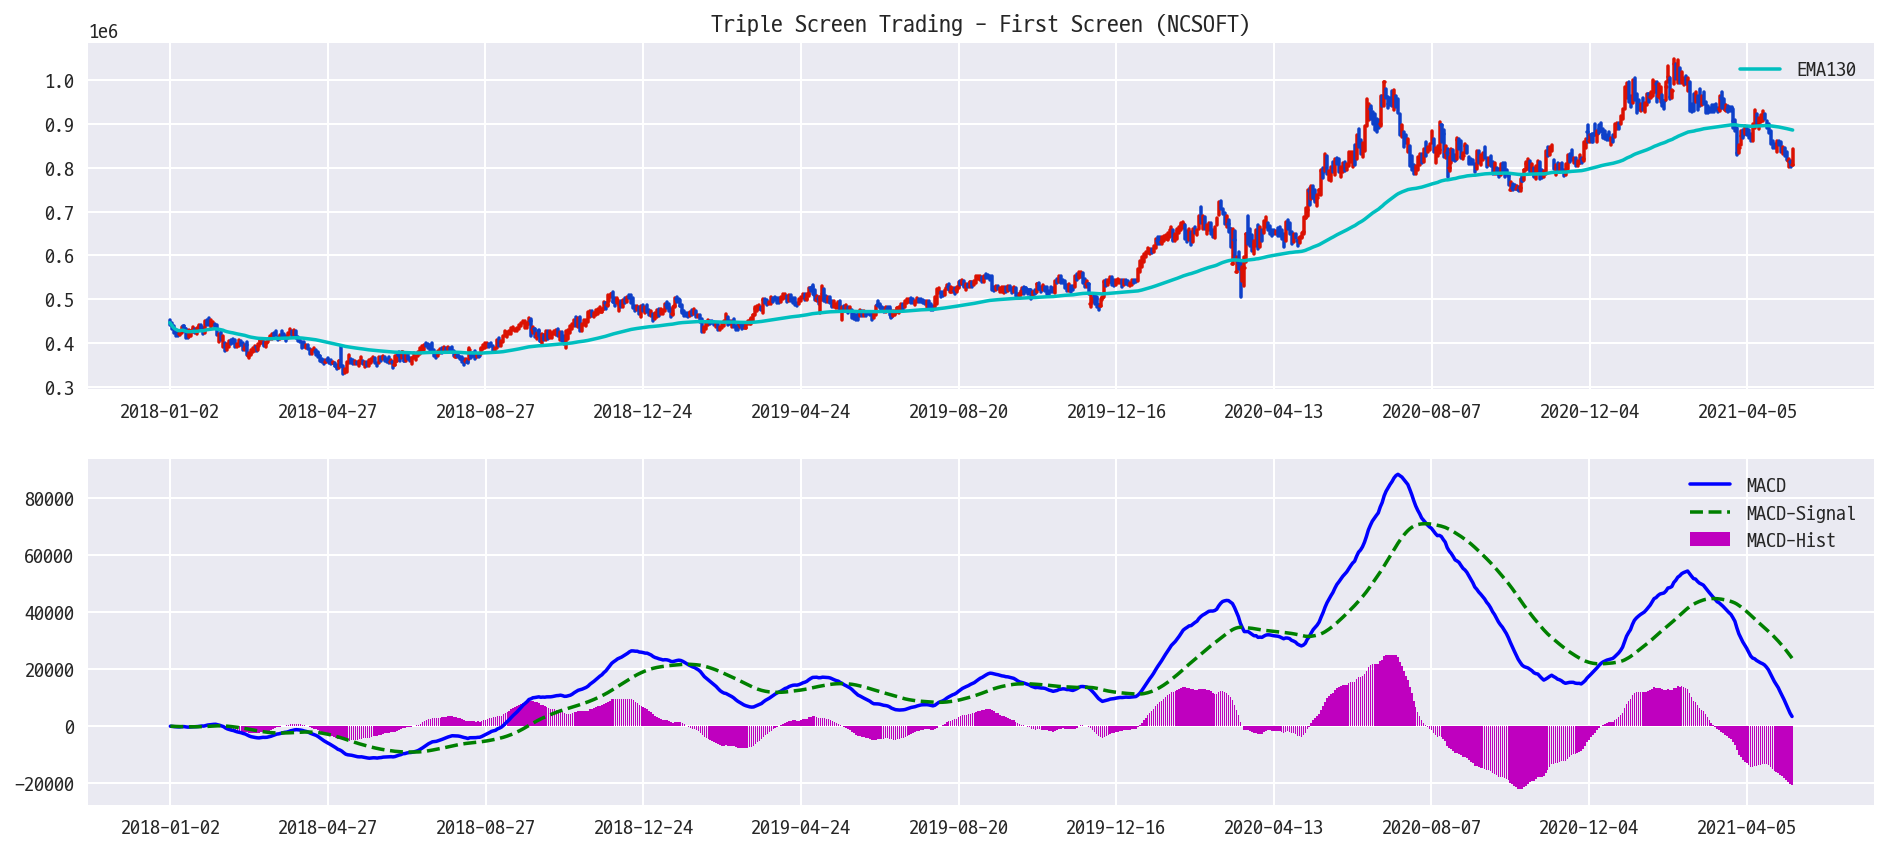

In [5]:
plt.figure(figsize=(16, 7))

# Chart 1 : OHLC Chart
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - First Screen (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

# Chart 2 : Signal Chart
p2 = plt.subplot(2, 1, 2)
plt.bar(ohlc.index, ohlc['macdhist'], color='m', label='MACD-Hist')
plt.plot(ohlc['macd'], color='b', label='MACD')
plt.plot(ohlc['signal'], 'g--', label='MACD-Signal')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **2 두번째 창 - Market Wave(시장파도)**
## **01 오실레이터 (oscillator) 데이터 추가하기**
loading the Naver Stock Price Table

In [6]:
data_df.head(3)

,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist
Date,,,,,,,,,,,
2018-01-02,448000,452500,442000,446500,121955,-0.002235,446500.000000,446500.000000,0.000000,0.000000,0.000000
2018-01-03,441500,446500,432000,435000,234234,-0.025756,440705.769231,440654.166667,-51.602564,-26.374644,-25.227920
2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453


In [7]:
ohlc = data_df.reset_index().copy()

ndays_high = ohlc.high.rolling(window=14, min_periods=1).max()      # 14일 간격 최댓값 정리
ndays_low = ohlc.low.rolling(window=14, min_periods=1).min()        # 14일 간격 최솟값 
fast_k = (ohlc.close - ndays_low) / (ndays_high - ndays_low) * 100  # %K : 빠른 신호선 추가
slow_d= fast_k.rolling(window=3).mean()                             # %D : 느린 신호선 (3일 %K 평균)

# "fast_k, slow_d" 컬럼 추가
ohlc = ohlc.assign(fast_k=fast_k, slow_d=slow_d).dropna() 
ohlc = ohlc.reset_index(drop=True)
ohlc.head(3)

,Date,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist,fast_k,slow_d
0,2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453,1.639344,19.710211
1,2018-01-05,426500,430000,417000,422000,204527,-0.001183,431334.949229,431143.279645,-191.669585,-100.425299,-91.244286,14.084507,10.119333
2,2018-01-08,422000,425000,415000,420000,143648,-0.004739,428997.673468,428763.612858,-234.060611,-129.579675,-104.480936,13.333333,9.685728


## **02 Visualization**
loading the Naver Stock Price Table

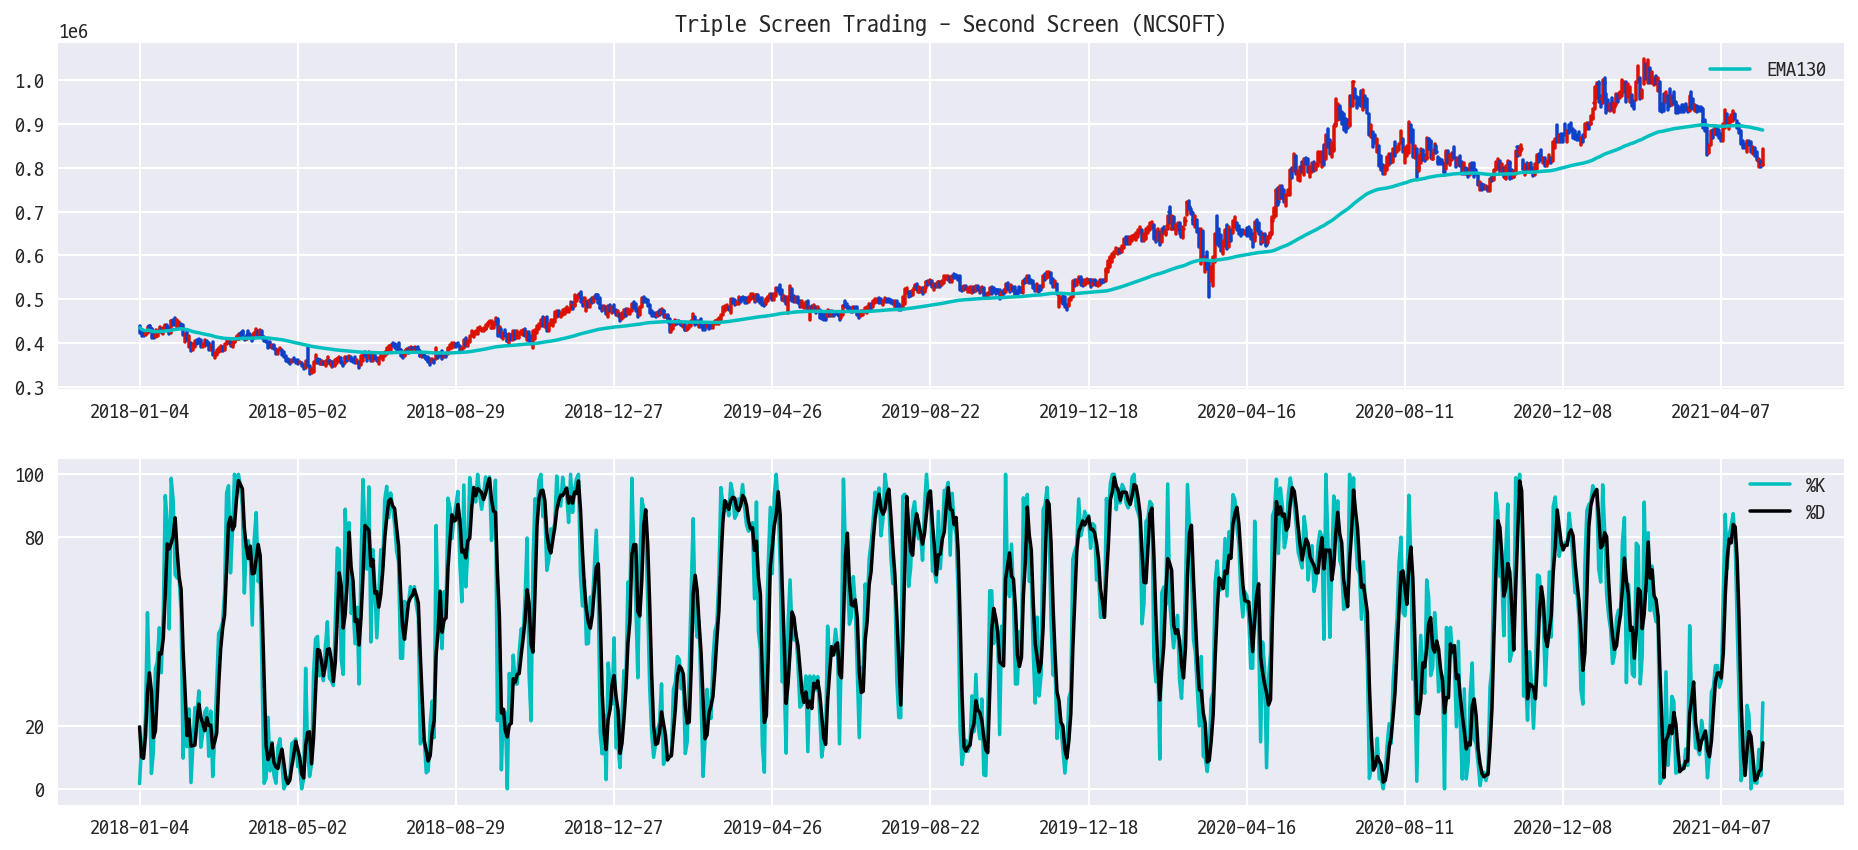

In [8]:
plt.figure(figsize=(16, 7))

# Chart 1 : OHLC Chart
p1 = plt.subplot(2, 1, 1)
plt.title('Triple Screen Trading - Second Screen (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

# Chart 2 : Signal Chart
p2 = plt.subplot(2, 1, 2)
plt.grid(True)
plt.plot(ohlc['fast_k'], color='c', label='%K')
plt.plot(ohlc['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100]) # 신호선 Y측 기준값을 정의한다
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **3 세 번째 창 - 진입기술 (Entry Technique)**
## **01 오실레이터 (oscillator) 데이터 추가하기**
loading the Naver Stock Price Table

In [9]:
ohlc = data_df.reset_index().copy()
ohlc.head(3)

,Date,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist
0,2018-01-02,448000,452500,442000,446500,121955,-0.002235,446500.000000,446500.000000,0.000000,0.000000,0.000000
1,2018-01-03,441500,446500,432000,435000,234234,-0.025756,440705.769231,440654.166667,-51.602564,-26.374644,-25.227920
2,2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453


In [10]:
# 진입시점 오실레이터 추가
ema60    = ohlc.close.ewm(span=60).mean()
ema130   = ohlc.close.ewm(span=130).mean()
macd     = ema60 - ema130
signal   = macd.ewm(span=45).mean()
macdhist = macd - signal
ohlc     = ohlc.assign(
    ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist
).dropna()

ndays_high = ohlc.high.rolling(window=14, min_periods=1).max()
ndays_low  = ohlc.low.rolling(window=14, min_periods=1).min()

fast_k = (ohlc.close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
ohlc = ohlc.assign(fast_k=fast_k, slow_d=slow_d).dropna()
ohlc = ohlc.reset_index(drop=True)
ohlc.head(3)

,Date,open,high,low,close,volume,change,ema130,ema60,macd,signal,macdhist,fast_k,slow_d
0,2018-01-04,438500,438500,422000,422500,284220,-0.028736,434543.579022,434399.962966,-143.616056,-67.204602,-76.411453,1.639344,19.710211
1,2018-01-05,426500,430000,417000,422000,204527,-0.001183,431334.949229,431143.279645,-191.669585,-100.425299,-91.244286,14.084507,10.119333
2,2018-01-08,422000,425000,415000,420000,143648,-0.004739,428997.673468,428763.612858,-234.060611,-129.579675,-104.480936,13.333333,9.685728


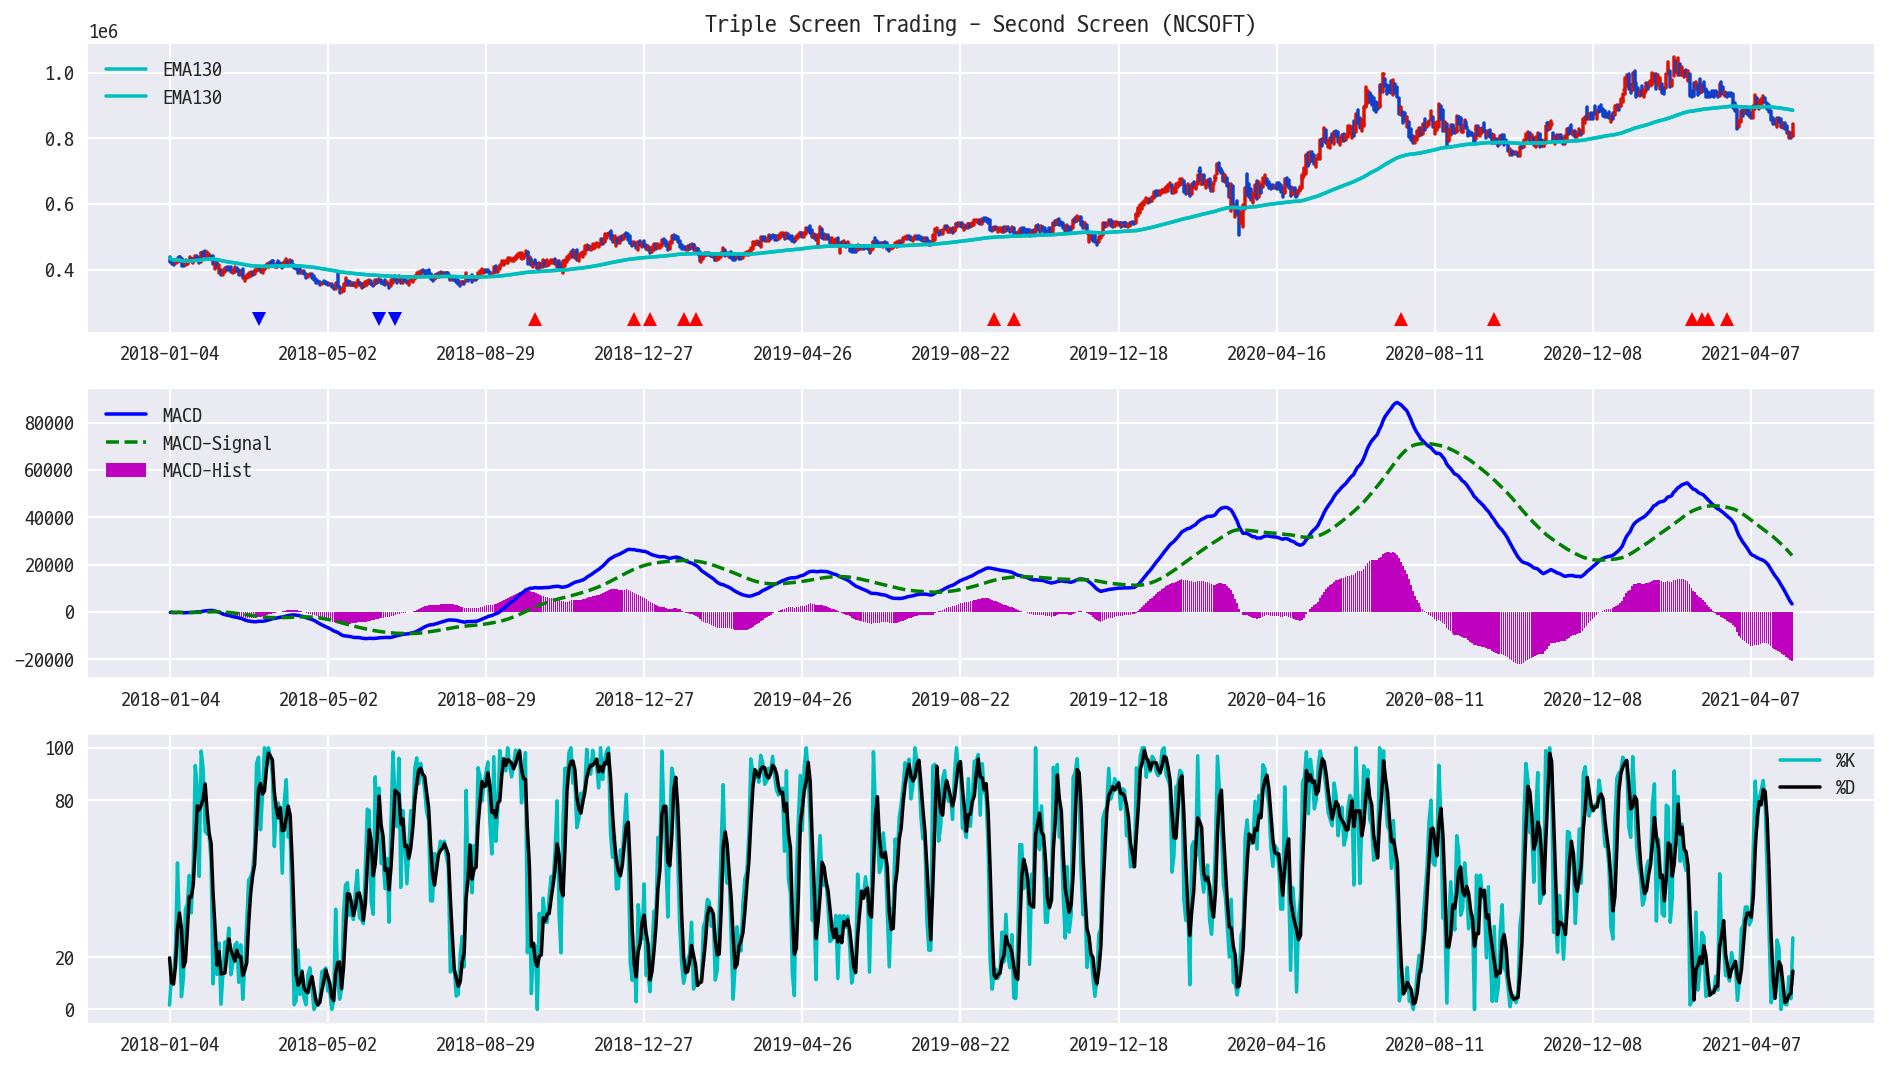

In [11]:
# Chart 1 : OHLC Chart
plt.figure(figsize=(16, 9))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)

# ohlc Chart 그리기
x = np.arange(0, len(ohlc))
for _, val in ohlc.iterrows():
    if val['close'] > val['open']: color = "#db1102" # 종가 상승
    else: color = "#0e40c9"                          # 종가 하락
    p1.plot([ x[_], x[_]], [val['low'], val['high']], color=color)     # High, Low Marker
    p1.plot([ x[_], x[_]-.1], [val['open'], val['open']], color=color) # Open Marker
    p1.plot([ x[_], x[_]+.1], [val['close'], val['close']], color=color) # close Marker

# ema130 Chart 추가하기
p1.plot(ohlc['ema130'], color='c', label='EMA130')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.plot(ohlc['ema130'], color='c', label='EMA130')

for i in range(1, len(ohlc.close)):
    if ohlc.ema130.values[i-1] < ohlc.ema130.values[i] and \
        ohlc.slow_d.values[i-1] >= 20 and ohlc.slow_d.values[i] < 20:
        plt.plot(ohlc.index[i], 250000, 'r^') 
    elif ohlc.ema130.values[i-1] > ohlc.ema130.values[i] and \
        ohlc.slow_d.values[i-1] <= 80 and ohlc.slow_d.values[i] > 80:
        plt.plot(ohlc.index[i], 250000, 'bv')

plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
plt.bar(ohlc.index, ohlc['macdhist'], color='m', label='MACD-Hist')
plt.plot(ohlc['macd'], color='b', label='MACD')
plt.plot(ohlc['signal'], 'g--', label='MACD-Signal')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
plt.grid(True)
plt.plot(ohlc['fast_k'], color='c', label='%K')
plt.plot(ohlc['slow_d'], color='k', label='%D')
plt.xticks(x[::80], ohlc.Date.dt.date[::80])
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()

## **02 지수 이동평균 (Exponential Moving Averages)**
**[Pandas EWM 이동평균 구현방식](https://www.openaitrading.com/python-pandas-%EC%9D%B4%EB%8F%99%ED%8F%89%EA%B7%A0-%EA%B5%AC%ED%95%98%EA%B8%B0/)**
$$ EMA = P_{today} \times K + EMA_{yesterday} \times (1-K) $$

In [12]:
# https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

In [13]:
# https://towardsdatascience.com/trading-toolbox-02-wma-ema-62c22205e2a9

## **02 일중 강도율**
거래 범위 내에서 **<span style="color:orange">종가의 위치</span>** 를 토대로 종목내 자금 흐름을 설명한다

$$ 일중강도 = {\frac{2 \times close-high-low}{high-low}} \times volume $$
$$ 일중 강도율 = {\frac{ 일중강도 21일 합계 }{ 거래량 21일 합계 }} \times 100 $$